In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from read_data import DataLoader
import optuna
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
sns.set_palette("viridis")
np.random.seed(42)

In [7]:
loader= DataLoader()
df= loader.load_data()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions
datetime,,,,,,,,,,
2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,"Rain, Partially cloudy"
2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,"Rain, Partially cloudy"
2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,Partially cloudy
2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,Partially cloudy
2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy


In [8]:
# === Check is the data stationary ===
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts):
    result = adfuller(ts)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")
    if result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

check_stationarity(df['Global_active_power'])

# How is this stationary?
# The time series is stationary because the p-value from the Augmented Dickey-Fuller test is less than 0.05, 
# indicating that we can reject the null hypothesis of a unit root in the time series. 
# This suggests that the statistical properties of the series (mean, variance) do not change over time.


ADF Statistic: -6.048224797037445
p-value: 1.296318628148782e-07
Critical Value 1%: -3.4349634933241084
Critical Value 5%: -2.8635775363009244
Critical Value 10%: -2.5678547733584605
The time series is stationary.


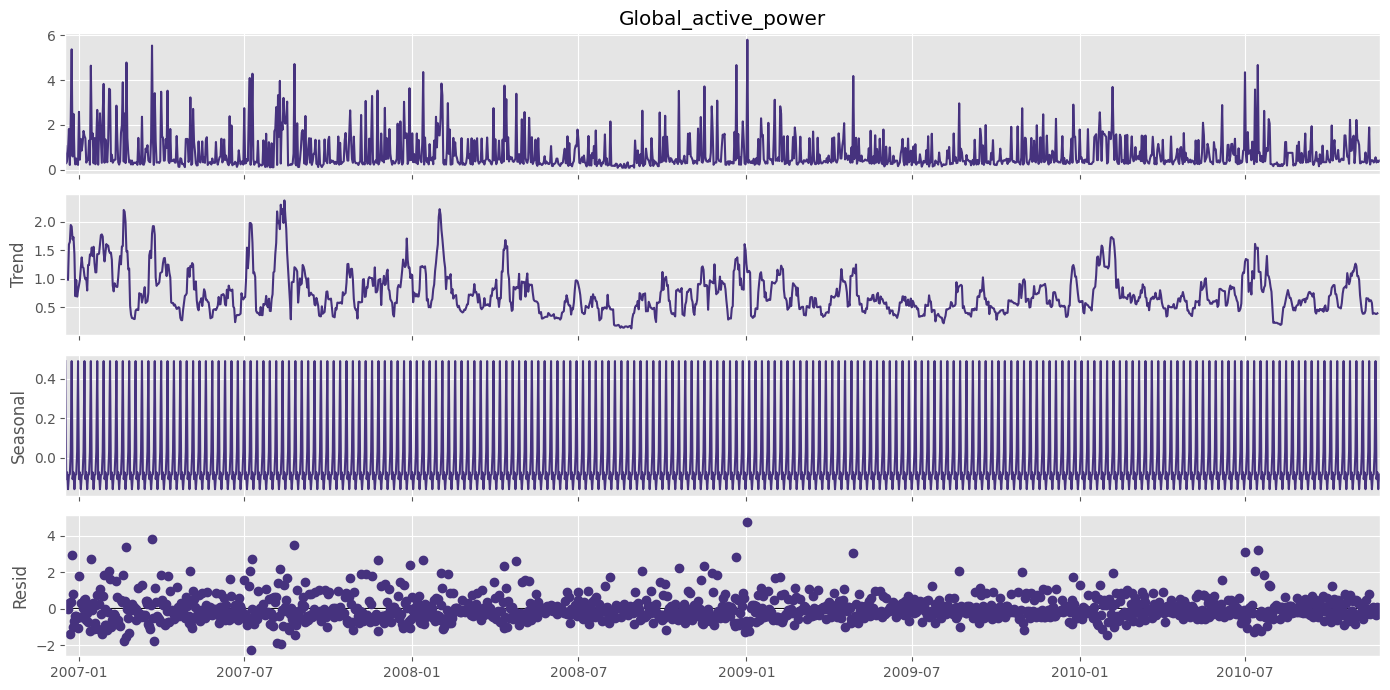

In [12]:
# Decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_time_series(ts):
    decomposition = seasonal_decompose(ts, model='additive')
    decomposition.plot()
    plt.show()
decompose_time_series(df['Global_active_power'])


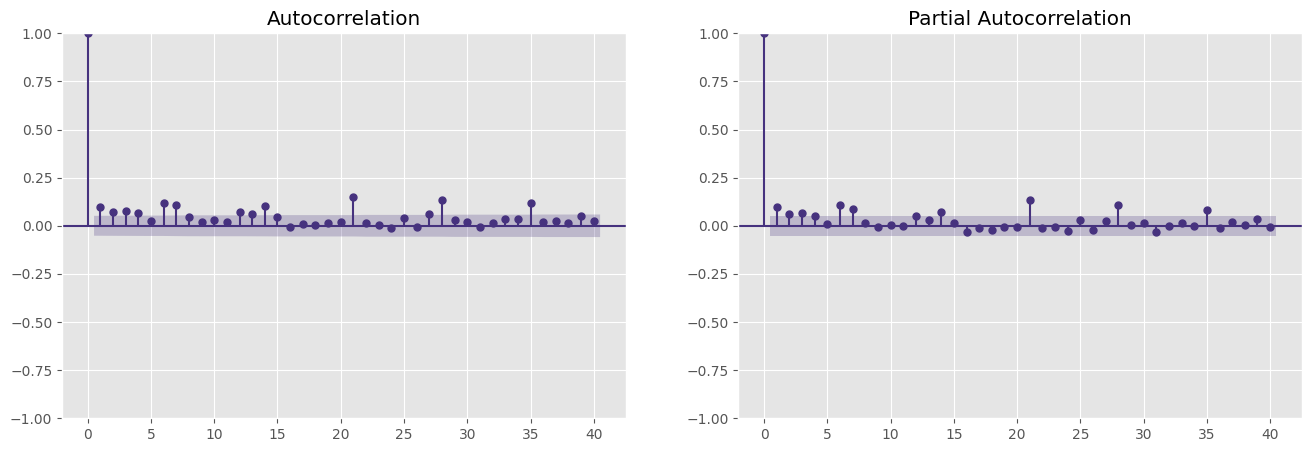

In [13]:
# === Check ACF/PACF ===
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(ts, lags=40):
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(ts, lags=lags, ax=ax[0])
    plot_pacf(ts, lags=lags, ax=ax[1])
    plt.show()
plot_acf_pacf(df['Global_active_power'])


In [ ]:
# Above plot about ACF and PCAF suggest:
# The ACF plot suggests that the time series has a long memory, indicating that it may require differencing to achieve stationarity.
# The PACF plot suggests that the series may be AR(1) or AR(2), as it shows a significant spike at lag 1 and then tapers off.

In [26]:
# Create time series dataset for Basic ARIMA model
ts_data = df[['Global_active_power']].copy()

# Split data (last 3 months for test)
split_date = '2010-06-01'
train = ts_data[ts_data.index < split_date]
test = ts_data[ts_data.index >= split_date]

print(f"Train size: {train.shape[0]} days ({train.index.min().date()} to {train.index.max().date()})")
print(f"Test size: {test.shape[0]} days ({test.index.min().date()} to {test.index.max().date()})")

Train size: 1260 days (2006-12-19 to 2010-05-31)
Test size: 179 days (2010-06-01 to 2010-11-26)


In [27]:
print(f"Train data:\n{train.head()}")
print(f"Test data:\n{test.head()}")

Train data:
            Global_active_power
datetime                       
2006-12-19                0.414
2006-12-20                0.824
2006-12-21                1.814
2006-12-22                0.206
2006-12-23                2.328
Test data:
            Global_active_power
datetime                       
2010-06-01                0.326
2010-06-02                0.412
2010-06-03                0.312
2010-06-04                0.382
2010-06-05                1.096


In [28]:
df['GAP_1diff'] = df['Global_active_power'].diff()
df.dropna(subset=['GAP_1diff'], inplace=True)
check_stationarity(df['GAP_1diff'])

ADF Statistic: -14.505445855803956
p-value: 5.839347272604831e-27
Critical Value 1%: -3.4349700122033804
Critical Value 5%: -2.8635804131233096
Critical Value 10%: -2.567856305330816
The time series is stationary.


In [29]:
# === ARIMA Model ===
def arima_objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)
    
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        aic = model_fit.aic
        return aic
    except:
        return float('inf')

# Optimize ARIMA parameters
arima_study = optuna.create_study(direction='minimize')
arima_study.optimize(arima_objective, n_trials=50)

# Get best parameters
best_arima_params = arima_study.best_params
print(f"Best ARIMA parameters: {best_arima_params}")

# Train and evaluate ARIMA
arima_model = ARIMA(train, order=(
    best_arima_params['p'], 
    best_arima_params['d'], 
    best_arima_params['q']
))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

[I 2025-06-03 22:11:34,882] A new study created in memory with name: no-name-cc27b066-3b50-4afa-b7f9-2e43fb61860d
[I 2025-06-03 22:11:35,245] Trial 0 finished with value: 3003.564702380929 and parameters: {'p': 5, 'd': 1, 'q': 1}. Best is trial 0 with value: 3003.564702380929.
[I 2025-06-03 22:11:35,751] Trial 1 finished with value: 3011.984856870917 and parameters: {'p': 0, 'd': 2, 'q': 2}. Best is trial 0 with value: 3003.564702380929.
[I 2025-06-03 22:11:36,033] Trial 2 finished with value: 2999.6534515807243 and parameters: {'p': 2, 'd': 1, 'q': 2}. Best is trial 2 with value: 2999.6534515807243.
[I 2025-06-03 22:11:36,747] Trial 3 finished with value: 3000.691260121521 and parameters: {'p': 2, 'd': 0, 'q': 5}. Best is trial 2 with value: 2999.6534515807243.
[I 2025-06-03 22:11:37,080] Trial 4 finished with value: 3001.6317356136315 and parameters: {'p': 3, 'd': 1, 'q': 2}. Best is trial 2 with value: 2999.6534515807243.
[I 2025-06-03 22:11:38,533] Trial 5 finished with value: 2998

Best ARIMA parameters: {'p': 1, 'd': 0, 'q': 1}


ARIMA - MAE: 0.4635459274950056, MSE: 0.4713773060230937, RMSE: 0.6865692288641355, R2: -0.006990938176616224


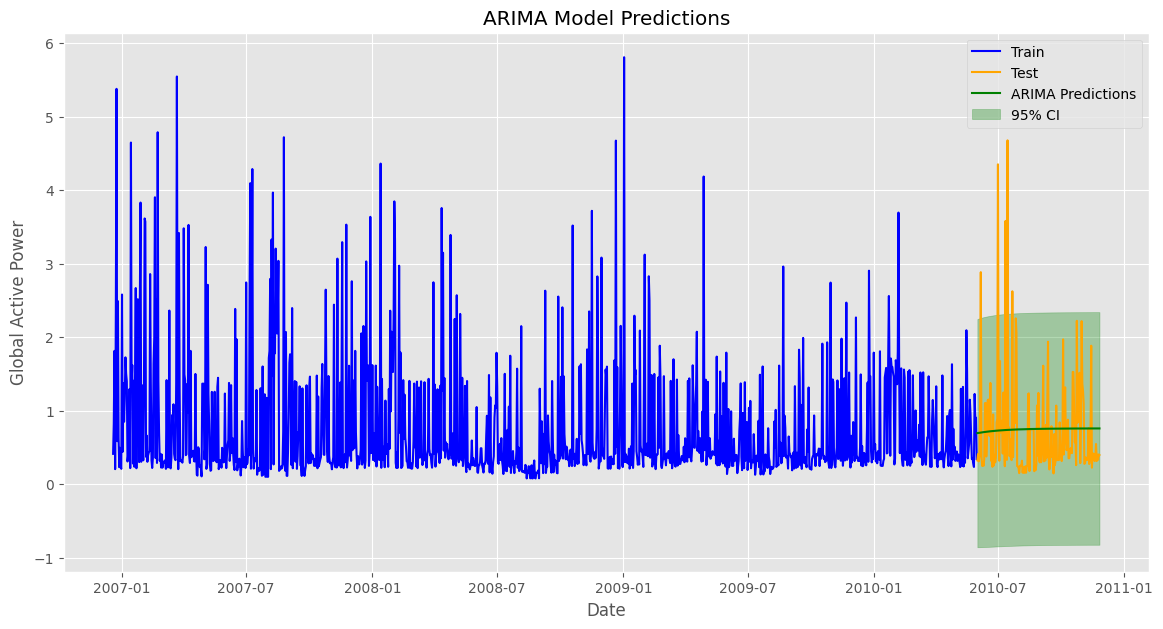

In [30]:
# If you want to use exogenous variables, make sure they exist in both train and test
# For this example, let's use only 'Global_active_power' as in your train/test splits

model = ARIMA(
    train,
    order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q'])
)
model_fit = model.fit()

# Forecast
predictions = model_fit.forecast(steps=len(test))

# Evaluation
matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'Predicted': predictions
})
mae = mean_absolute_error(matrix['Actual'], matrix['Predicted'])
mse = mean_squared_error(matrix['Actual'], matrix['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(matrix['Actual'], matrix['Predicted'])
print(f"ARIMA - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

# Plot ARIMA predictions with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='green')

conf_int = model_fit.get_forecast(steps=len(test)).conf_int()
plt.fill_between(
    test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green', alpha=0.3, label='95% CI'
)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

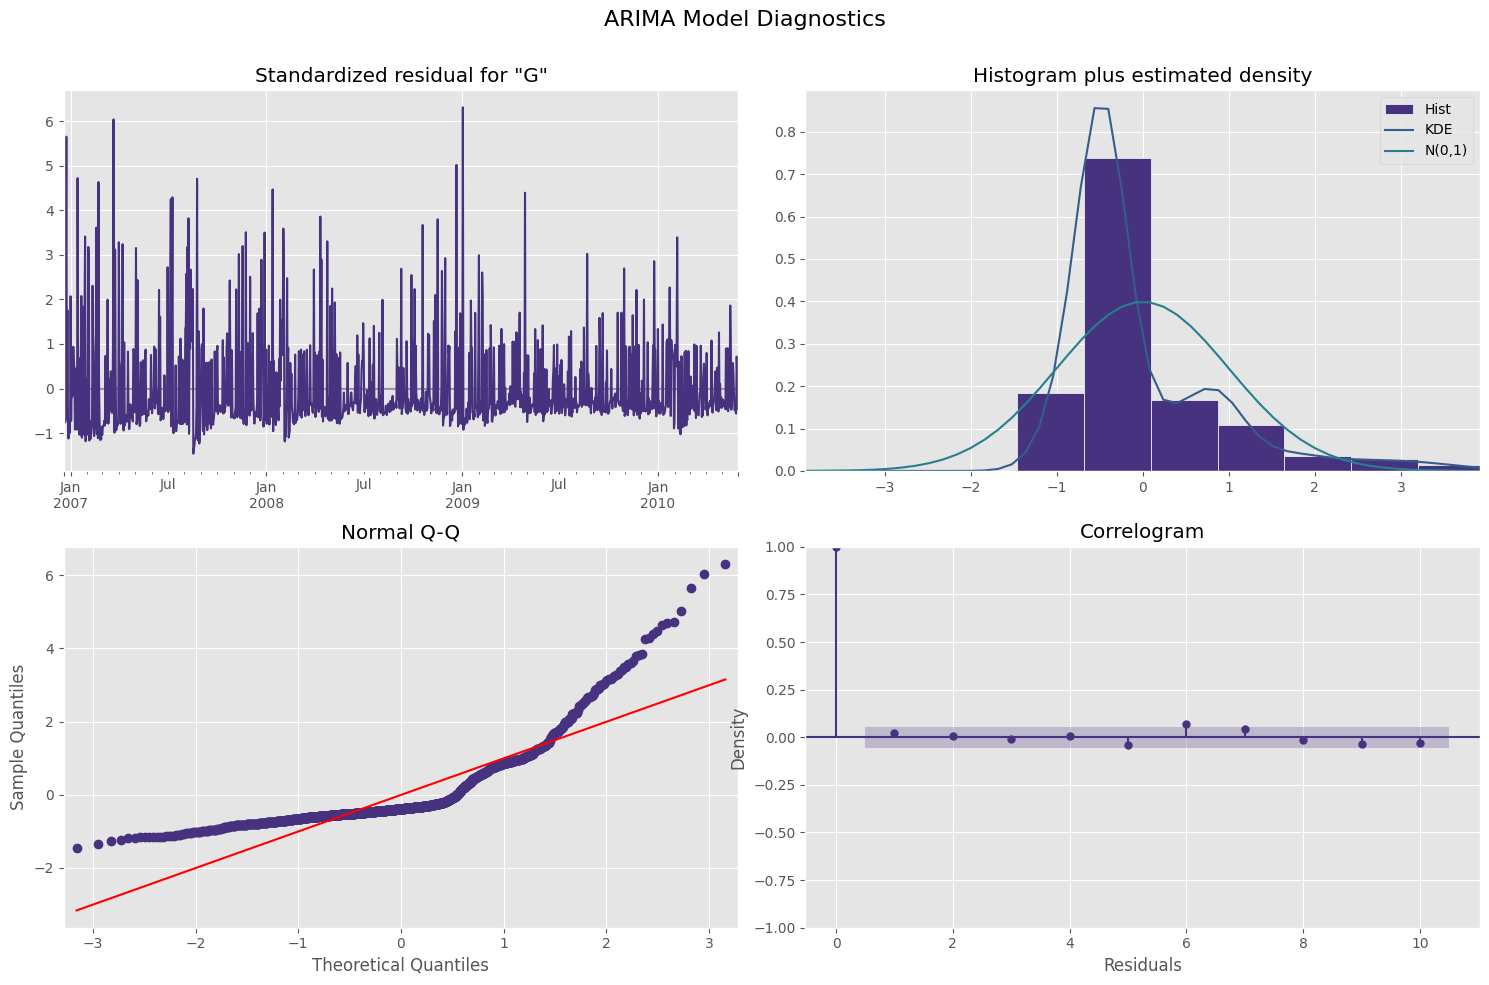

In [31]:
# Plot ARIMA diagnostics (residuals, standardized residuals, etc.)
model_fit.plot_diagnostics(figsize=(15, 10))
plt.suptitle('ARIMA Model Diagnostics', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

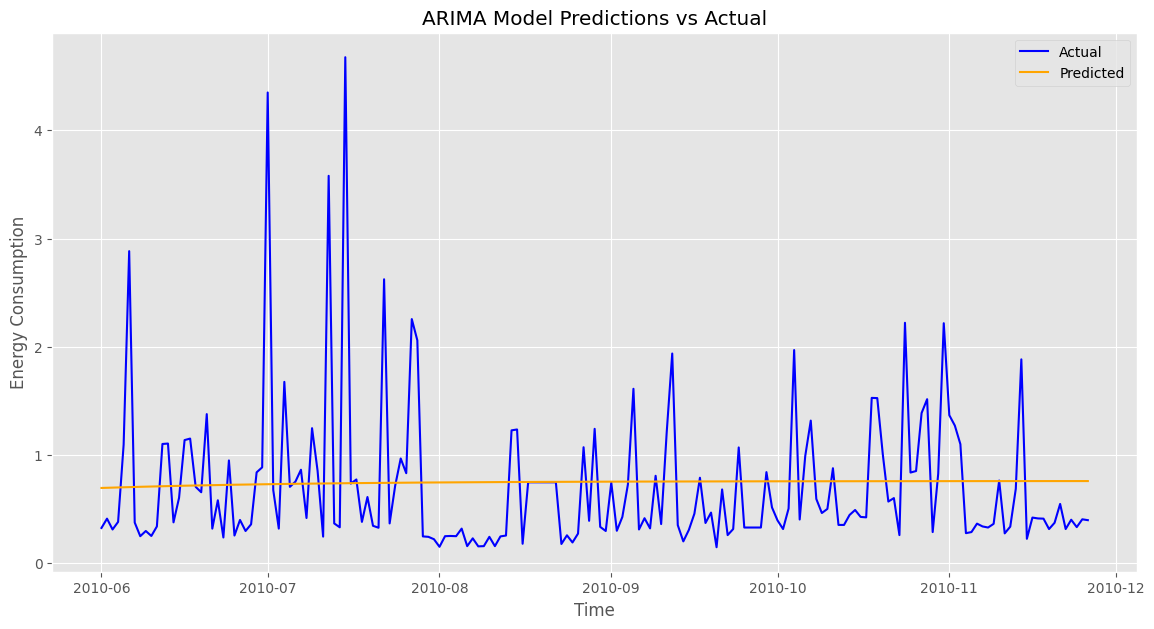

In [32]:
# plot the error in the predictions
plt.figure(figsize=(14, 7))
plt.plot(matrix['Actual'], label='Actual', color='blue')
plt.plot(matrix['Predicted'], label='Predicted', color='orange')
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


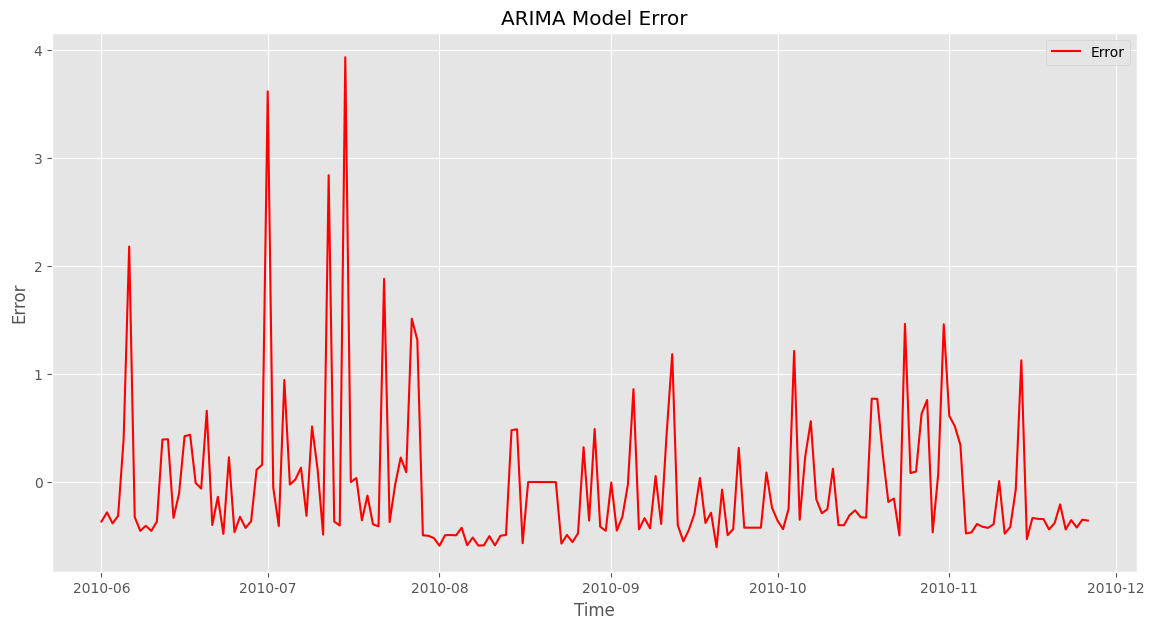

In [33]:
# plot the error of the arima model
plt.figure(figsize=(14, 7))
plt.plot(matrix['Actual'] - matrix['Predicted'], label='Error', color='red')
plt.title('ARIMA Model Error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()

ARIMA with Exogenous - MAE: 0.2887652018578042, MSE: 0.15132149714066198, RMSE: 0.38900063899775533, R2: 0.6767358665236634


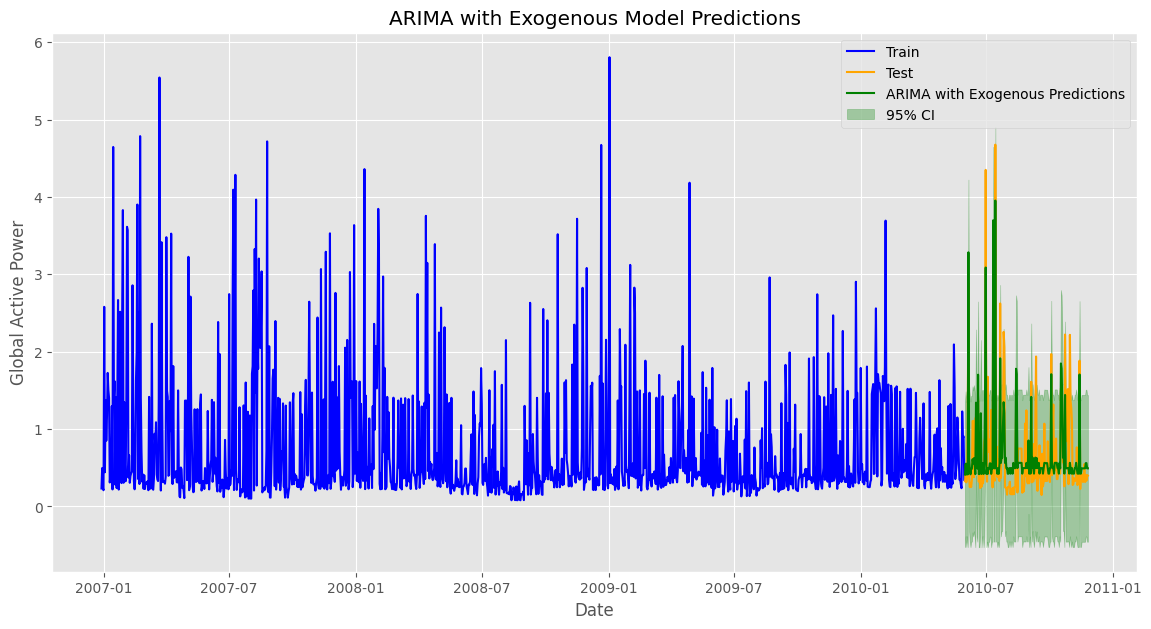

In [ ]:
df['GAP_lag1'] = df['Global_active_power'].shift(1)
df.dropna(subset=['GAP_lag1'], inplace=True)

# Recreate train and test to include the new column
train = df[df.index < split_date]
test = df[df.index >= split_date]

train_exog = train[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3' ]]
test_exog = test[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3' ]]

# Train ARIMA with exogenous variable
arima_exog_model = ARIMA(
    train['Global_active_power'],
    order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']),
    exog=train_exog
)
arima_exog_fit = arima_exog_model.fit()
# Forecast with exogenous variable
arima_exog_pred = arima_exog_fit.forecast(steps=len(test), exog=test_exog)
# Evaluation with exogenous variable
arima_exog_matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'Predicted': arima_exog_pred
})
ma_exog_mae = mean_absolute_error(arima_exog_matrix['Actual'], arima_exog_matrix['Predicted'])
ma_exog_mse = mean_squared_error(arima_exog_matrix['Actual'], arima_exog_matrix['Predicted'])
ma_exog_rmse = np.sqrt(ma_exog_mse)
ma_exog_r2 = r2_score(arima_exog_matrix['Actual'], arima_exog_matrix['Predicted'])
print(f"ARIMA with Exogenous - MAE: {ma_exog_mae}, MSE: {ma_exog_mse}, RMSE: {ma_exog_rmse}, R2: {ma_exog_r2}")
# Plot ARIMA with exogenous variable predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, arima_exog_pred, label='ARIMA with Exogenous Predictions', color='green')
conf_int_exog = arima_exog_fit.get_forecast(steps=len(test), exog=test_exog).conf_int()
plt.fill_between(
    test.index,
    conf_int_exog.iloc[:, 0],
    conf_int_exog.iloc[:, 1],
    color='green', alpha=0.3, label='95% CI'
)
plt.title('ARIMA with Exogenous Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

ARIMA model error graph shows that the error fluctuates between -0.30 and 0.10, which is a relatively narrow range.

Model Performance:
- No Extreme Spikes → Since there are no large jumps in error, your model is relatively stable and not making drastically incorrect predictions.
- Centered Around Zero? → Ideally, residuals should oscillate around zero. If the error consistently leans toward negative or positive values, it suggests bias in the model.
- Seasonal Patterns? → If the error follows a regular pattern, Model might be missing seasonality or some important features.
- If the error looks random → That’s great! It means the model is working correctly, leaving only random noise.

In [42]:
# === Feature Engineering ===
def feature_engineering(df):
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    df['Weekday'] = df.index.weekday
    return df   
df = feature_engineering(df)

ARIMA with Feature Engineering - MAE: 0.44819469995785755, MSE: 0.46609625704088514, RMSE: 0.6827124263120492, R2: 0.004290827833753119


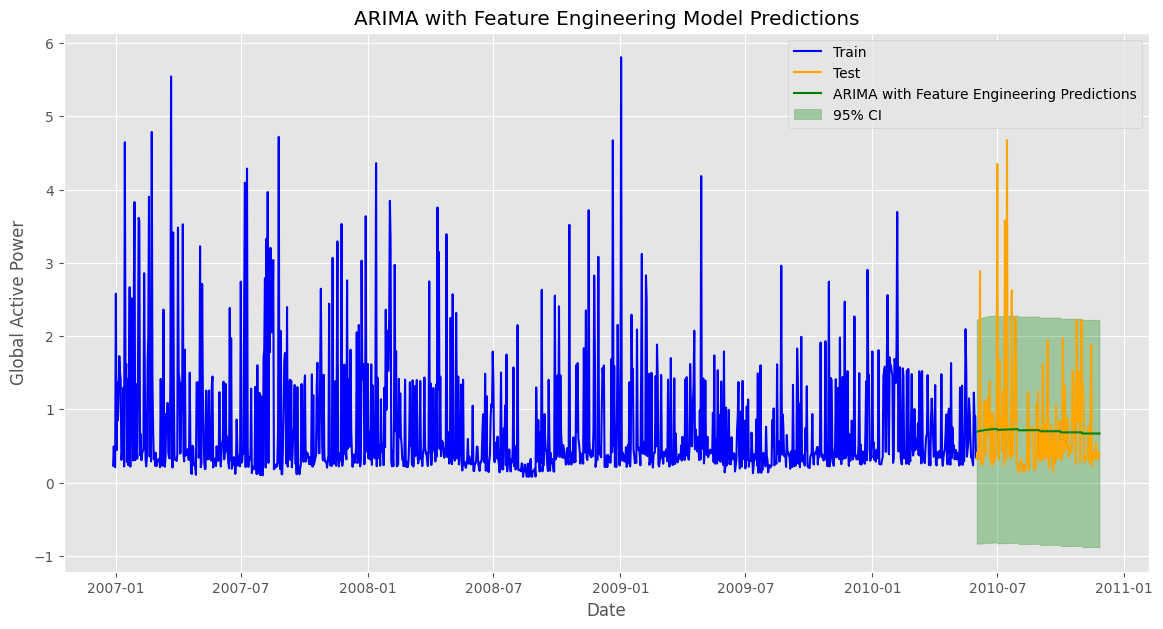

In [54]:
# Recreate train and test from the updated df after feature engineering
train = df[df.index < split_date]
test = df[df.index >= split_date]

train_exog = train[[ 'Month']]
test_exog = test[[ 'Month']]
arima_model = ARIMA(
    train['Global_active_power'],
    order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']),
    exog=train_exog
)   
arima_fit = arima_model.fit()
# Forecast with feature engineered exogenous variables
arima_pred = arima_fit.forecast(steps=len(test), exog=test_exog)
# Evaluation with feature engineered exogenous variables

arima_matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'Predicted': arima_pred
})
mae = mean_absolute_error(arima_matrix['Actual'], arima_matrix['Predicted'])
mse = mean_squared_error(arima_matrix['Actual'], arima_matrix['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(arima_matrix['Actual'], arima_matrix['Predicted'])
print(f"ARIMA with Feature Engineering - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")
# Plot ARIMA with feature engineered exogenous variable predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, arima_pred, label='ARIMA with Feature Engineering Predictions', color='green')
conf_int = arima_fit.get_forecast(steps=len(test), exog=test_exog).conf_int()
plt.fill_between(
    test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green', alpha=0.3, label='95% CI'
)
plt.title('ARIMA with Feature Engineering Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [55]:
# Calculate sub metering other is the sum of sub metering 1, 2, and 3 and subtracting from global active power
df['Sub_metering_Other'] = df['Global_active_power'] - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

ARIMA with Sub Metering - MAE: 2.6293833652899676e-14, MSE: 1.5738937029719376e-27, RMSE: 3.967232918511261e-14, R2: 1.0


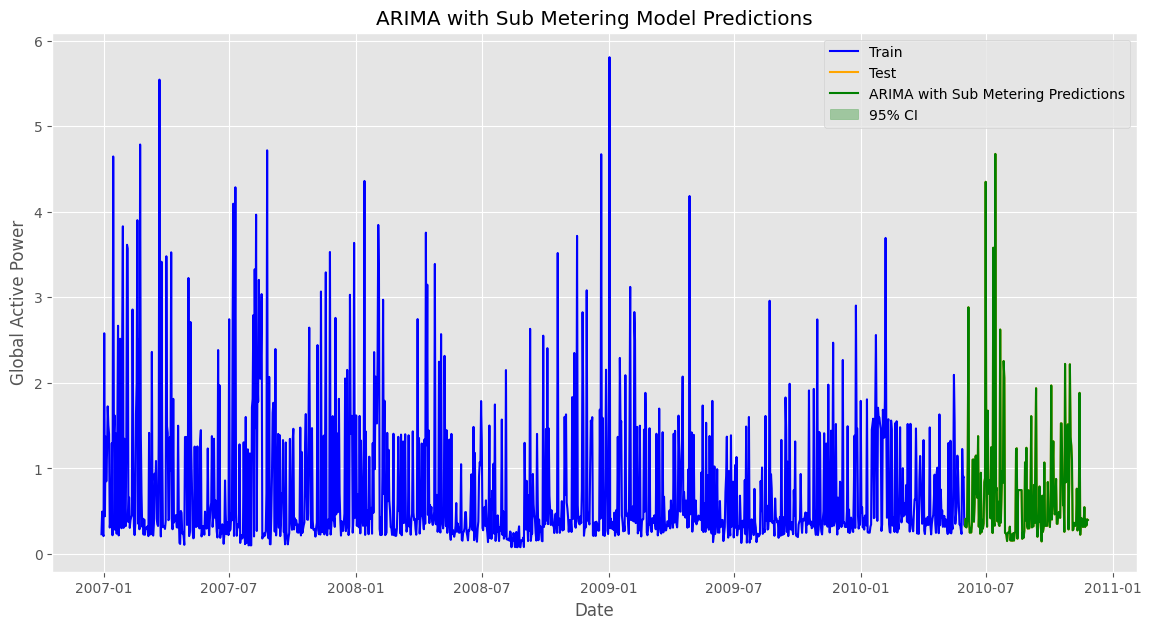

In [57]:
# Recreate train and test to include the new 'Sub_metering_Other' column
train = df[df.index < split_date]
test = df[df.index >= split_date]

train_exog = train[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_Other']]
test_exog = test[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_Other']]

arima_model = ARIMA(
    train['Global_active_power'],
    order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']),
    exog=train_exog
)
arima_fit = arima_model.fit()
# Forecast with sub metering exogenous variables
arima_pred = arima_fit.forecast(steps=len(test), exog=test_exog)
# Evaluation with sub metering exogenous variables
arima_matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'Predicted': arima_pred
})  
mae = mean_absolute_error(arima_matrix['Actual'], arima_matrix['Predicted'])
mse = mean_squared_error(arima_matrix['Actual'], arima_matrix['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(arima_matrix['Actual'], arima_matrix['Predicted'])
print(f"ARIMA with Sub Metering - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")
# Plot ARIMA with sub metering exogenous variable predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, arima_pred, label='ARIMA with Sub Metering Predictions', color='green')
conf_int = arima_fit.get_forecast(steps=len(test), exog=test_exog).conf_int()
plt.fill_between(
    test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green', alpha=0.3, label='95% CI'
)
plt.title('ARIMA with Sub Metering Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()
# === Conclusion ===


ARIMA with Sub Metering - MAE: 0.029340027831647457, MSE: 0.0019717340757685353, RMSE: 0.04440421236514094, R2: 0.9957878363650038


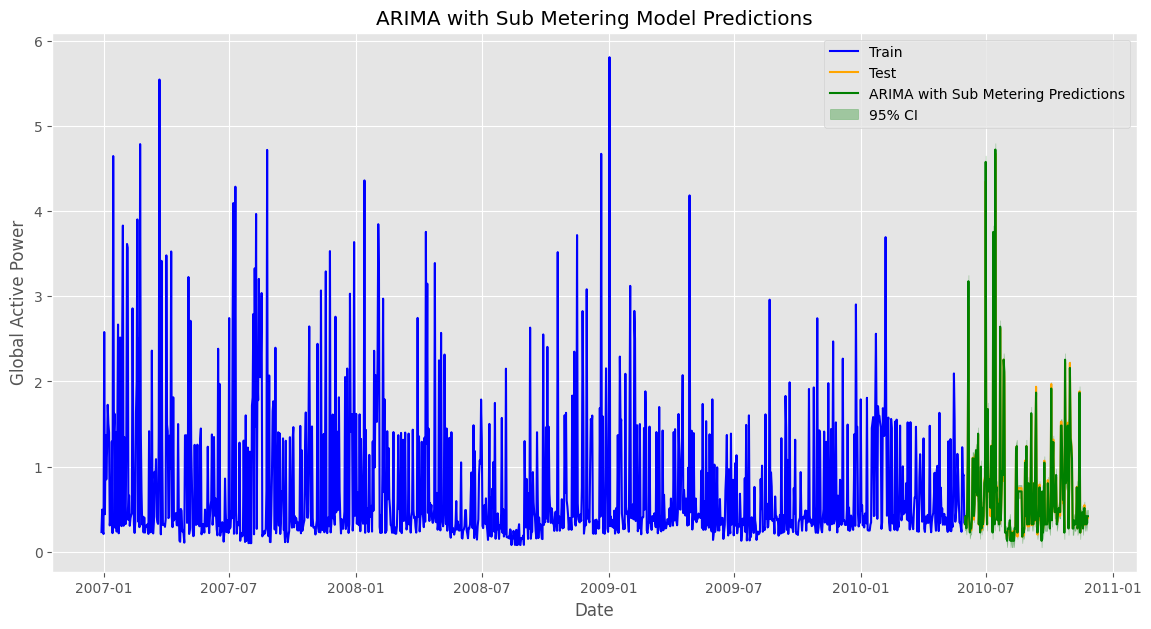

In [58]:
train = df[df.index < split_date]
test = df[df.index >= split_date]

train_exog = train[['Global_intensity', ]]
test_exog = test[['Global_intensity', ]]

arima_model = ARIMA(
    train['Global_active_power'],
    order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']),
    exog=train_exog
)
arima_fit = arima_model.fit()
# Forecast with sub metering exogenous variables
arima_pred = arima_fit.forecast(steps=len(test), exog=test_exog)
# Evaluation with sub metering exogenous variables
arima_matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'Predicted': arima_pred
})  
mae = mean_absolute_error(arima_matrix['Actual'], arima_matrix['Predicted'])
mse = mean_squared_error(arima_matrix['Actual'], arima_matrix['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(arima_matrix['Actual'], arima_matrix['Predicted'])
print(f"ARIMA with Sub Metering - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")
# Plot ARIMA with sub metering exogenous variable predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, arima_pred, label='ARIMA with Sub Metering Predictions', color='green')
conf_int = arima_fit.get_forecast(steps=len(test), exog=test_exog).conf_int()
plt.fill_between(
    test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green', alpha=0.3, label='95% CI'
)
plt.title('ARIMA with Sub Metering Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()